# 75.06/95.58 Organización de Datos
# Primer Cuatrimestre de 2020
# Trabajo Práctico 2: Enunciado


El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

## Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

## El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.

## Forma de evaluar kaggle

Las presentaciones se evalúan utilizando F1 entre las respuestas previstas y esperadas.

F1 se calcula de la siguiente manera:

$ F1=(2∗precision∗recall)/(precision+recall) $

donde:

$precision=TP/(TP+FP)$

$recall=TP/(TP+FN)$


con:

- Verdadero positivo [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- Falso positivo [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- Falso Negativo [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

importaciones

In [1]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

#plt.style.use('default')
from gensim.sklearn_api import tfidf

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import math
#librerias para KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#red neuronal
from keras.models import Sequential
from keras.layers.core import Dense
#arboles de decicion
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#catboost
from catboost import CatBoostRegressor
#xgb
import xgboost as xgb

#palabras
import nltk
#nltk.download('stopwords')#si no tiene stopword habilitar esta linea
from nltk.corpus import stopwords
import gensim 
from gensim.models import Word2Vec 
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import lightgbm as lgb
from copy import deepcopy

Using TensorFlow backend.


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwordEnglis = stopwords.words('english')
#tfidf = TfidfVectorizer()


import spacy
# para activar este ultimo escribir en consola "python -m spacy download en_core_web_sm"
from spacy.lang.fi import Finnish
import en_core_web_sm

inicio de csv

In [3]:
tweets_original_entrenamiento = pd.read_csv('train.csv',index_col=['id'])
tweets_original_entrenamiento.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets_original_prueba = pd.read_csv('test.csv',index_col=['id'])
tweets_original_prueba.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


calculo resultado

In [5]:
#resultados
resultados_de_test = pd.read_csv('respuestas.csv',index_col=['id'])
#revisar los resultados
def calclarPresicionYRecall(df):
    respuestas = pd.read_csv('respuestas.csv',index_col=['id'])
    respuestas['prediccion'] = df['target']
    #respuestas['TP'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FP'] = [1 if (respuestas['target'] == 0 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FN'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 0) else 0]
    
    respuestas.loc[respuestas['prediccion'] + respuestas['target'] == 2 , 'TP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 1 , 'FP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 2 , 'FN'] = 1
    respuestas['TP'].fillna(0, inplace=True)
    respuestas['FP'].fillna(0, inplace=True)
    respuestas['FN'].fillna(0, inplace=True)

    tp = respuestas['TP'].sum()
    fp = respuestas['FP'].sum()
    fn = respuestas['FN'].sum()
    
    #print(tp,fp,fn)
    #print(respuestas.head())
    
    sumaPresicion = tp + fp
    sumaRecall = tp + fn
    presicion = tp / sumaPresicion
    recall = tp / sumaRecall
    return (presicion,recall)

def F1(df):
    presicion,recall = calclarPresicionYRecall(df)
    resultado = 2 * presicion * recall
    resultado /= (presicion + recall)
    return resultado

In [6]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
def eliminarErrorDeValores(df):
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

inicio de problema


In [7]:
#esto deberia ahorrar columnas al hacer un BOW
def digitos_en_binario(numero):
    logaritmo2 = math.log2(numero)
    entero = int(logaritmo2)
    entero += 1
    return entero

def transformar_a_vector_binario(numero,digitos):
    nBinario = aBinario(numero)
    digit = len(nBinario)
    while (digit < digitos):
        digit = len(nBinario)
        nBinario.insert(0,0)
    return nBinario

def aBinario(numero):
    numeroDecimal = numero
    numeroBinario = []
    if (numeroDecimal < 2):
        numeroBinario.append(numeroDecimal)
        return numeroBinario
    while numeroDecimal >=2:
        numeroBinario.append(numeroDecimal % 2)
        numeroDecimal //= 2
    numeroBinario.append(numeroDecimal)
    numeroBinario.reverse()
    return numeroBinario

#PRUEVA
#if (digitos_en_binario(63) != 6):
#    print("error en digitos_en_binario")
#bina = aBinario(64)
#if (bina != 6 and bina[0] != 1 and bina[1] != 0 and bina[2] != 0 and bina[3] != 0 and bina[4] != 0 and bina[5] != 0):
#    print("error en aBinario")
#print(transformar_a_vector_binario(64,8))
#TODO OK

In [8]:
"""
vacio = 0000
a = 0001
b = 0010
c = 0011
d = 0100
e = 0101
f = 0110
h = 0111
r = 1000
s = 1001
t = 1010
w = 1011
"""
LETRAS_0 = ['a','c','e','h','s','w']
def letra0(x):
    if (x in LETRAS_0):
        return 1
    return 0
LETRAS_1 = ['b','c','f','h','t','w']
def letra1(x):
    if (x in LETRAS_1):
        return 1
    return 0
LETRAS_2 = ['d','e','f','h']
def letra2(x):
    if (x in LETRAS_2):
        return 1
    return 0
LETRAS_3 = ['r','s','t','w']
def letra3(x):
    if (x in LETRAS_3):
        return 1
    return 0
def letra_inicial_Keyword_BOW(df):
    #for i in range(0,4):
    #    texto = 'letra_' + str(i)
    #    df[texto] = 0
    df['letra_0'] = 0
    df['letra_1'] = 0
    df['letra_2'] = 0
    df['letra_3'] = 0
    df['letra_0'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_1'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_2'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_3'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    return df
     

In [9]:

def set_palabras_del_train(df):
    palabrasTexto = []
    palabrasKeyword = []
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    return (palabrasTexto,palabrasKeyword)

def hashtag_en_tweet(listado):
    """defino hashtag como un numeral seguido por una cadena de texto"""
    contador = 0
    for palabra in listado:
        if (palabra[0] == '#'):
            contador += 1
    return contador

def cantidad_de_palabras_en_texto(lista,palabra):
    contador = 0
    for elemento in lista:
        if (elemento == palabra):
            contador += 1
    return contador

def localizacion(x,lista):
    if (x == ""):
        return 0
    for i in range(len(lista)):
        palabra = lista[i]
        if (palabra == x):
            return (i + 1)
    return 0

def ubicacionEnLista(x,pos):
    return x[pos]

def BOW_locacion(df,lista,columna):
    cantidadDePalabras = len(lista)
    if (cantidadDePalabras == 0):
        return df
    
    binarioMaximo = cantidadDePalabras + 1
    digitosBinario = digitos_en_binario(binarioMaximo)
    
    df[columna] = df[columna].map(lambda x: transformar_a_vector_binario(localizacion(x,lista),digitosBinario))
    for j in range(digitosBinario):
        df["{}_palabra_{}".format(columna,j)] = df[columna].map(lambda x: ubicacionEnLista(x,j))
    return df


In [10]:
def eliminar_signos(texto):
    palabra = ""
    for caracter in texto:
        if (caracter < 'a' or caracter > 'z'):
            continue
        palabra += caracter
    return palabra

In [11]:
def preparar_df(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento=[],listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento=[],listadoDePalabrasDelKeywordDelSetDeEntrenamiento=[]):
    df['text'].fillna("", inplace=True)
    df['keyword'].fillna("", inplace=True)
    df['location'].fillna("", inplace=True)
    
    df['longitud_de_texto'] = df['text'].str.len()
    df['longitud_de_keyword'] = df['keyword'].str.len()
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['keyword'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    df['cantidad_de_palabras_texto'] = df['palabras_de_texto'].map(len)
    df['cantidad_de_palabras_keyword'] = df['palabras_de_keyword'].map(len)
    
    df['cantidad_de_hashtag_en_texto'] = df['palabras_de_texto'].map(hashtag_en_tweet)
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelTextoDelSetDeEntrenamiento])
    #df['palabras_de_keyword'] = df['palabras_de_keyword'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelKeywordDelSetDeEntrenamiento])
    
    df = letra_inicial_Keyword_BOW(df)
    
    df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [eliminar_signos(item) for item in x])
    
    for palabra in listadoDePalabrasDelTextoDelSetDeEntrenamiento:
        df[palabra] = df['palabras_de_texto'].map(lambda x: cantidad_de_palabras_en_texto(x,palabra))
    
    df = BOW_locacion(df,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,'location')
    df = BOW_locacion(df,listadoDePalabrasDelKeywordDelSetDeEntrenamiento,'keyword')
    
    df['longitud_de_texto_sin_signos'] = df['text'].map(eliminar_signos).str.len()
    
    #df['text'] = df['text'].str.replace(r' ', '')
    #df['keyword'] = df['keyword'].str.replace(r' ', '')
    #df['location'] = df['location'].str.replace(r' ', '')
    
    #TF-IDF
    #x = TfidfVectorizer.fit_transform(df['palabras_de_texto'])
    #df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    #for col in df_tfidf.columns():
    #    df = df.join(df_tfidf[col])
    #df.join(df_tfidf)#mal planteado
    
    df = df.drop(columns=['id','keyword','text','location'])
    df = df.drop(columns=['palabras_de_texto','palabras_de_keyword'])
    
    return df

In [12]:
def extraer_palabras(serie):
    URL_INICIO = "http"
    lista = []
    #dic = {}
    for listado in serie:
        for elemento in listado:
            palabra = eliminar_signos(elemento)
            #la mayoria de las palabras en ingles tienen una esperansa de 4.8773 caracteres con varianza de 2.6171
            longitud = len(palabra)
            #simbolos = ('0','1','2','3','4','5','6','7','8','9','#','/','','"','@',';','?','[','(','{','.','!','$','&','*','-')
            #if (palabra in lista or longitud > 7 or longitud < 2 or palabra[0] in simbolos or palabra[-1] in simbolos or palabra[:4] == URL_INICIO):
            if (palabra in lista or longitud < 2 or palabra[:4] == URL_INICIO or palabra in stopwordEnglis):
                continue
            lista.append(elemento)
    #resultado = []
    #max = 0
    #for palabra in lista:
    #    max = dic[palabra]
    #    if (dic[palabra] < 800):
    #        continue
    #    resultado.append(palabra)
    return lista

def generar_lista(x,lista):
    if (x in lista or x == ""):
        return
    lista.append(x)
    return

ABRO LOS SETS

In [13]:
#train
train_label = tweets_original_entrenamiento['target']
train_set = deepcopy(tweets_original_entrenamiento)
train_set = train_set.drop(columns=['target'])
#test
test_set = deepcopy(tweets_original_prueba)

PROCESADO DE SET

In [14]:
def listadoDeElementos(df1,df2,columna):
    df1[columna].fillna("", inplace=True)
    df2[columna].fillna("", inplace=True)
    seriePalabrasDf1 = df1[columna].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    listadoDePalabrasDelDf1 = extraer_palabras(seriePalabrasDf1)
    seriePalabrasDf2 = df2[columna].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    listadoDePalabrasDelDf2 = extraer_palabras(seriePalabrasDf2)
    lista_final = {}
    for elem in listadoDePalabrasDelDf1:
        elemento = eliminar_signos(elem)
        if (not elemento in listadoDePalabrasDelDf2):
            continue
        if (elemento in lista_final.keys()):
            lista_final[elemento] += 1
        else:
            lista_final[elemento] = 1
    
    listadoDePalabras = []
    for clave in lista_final.keys():
        if (lista_final[clave] <= 1):
            continue
        listadoDePalabras.append(clave)
    
    print(len(listadoDePalabras))
    return listadoDePalabras

In [15]:
def fusionarTextoConKeyword(df1,df2):
    df1['text'] = df1['text'] + df1['keyword']
    df2['text'] = df2['text'] + df2['keyword']
    return df1,df2
train_set,test_set = fusionarTextoConKeyword(train_set,test_set)

In [16]:
#Recordar esta celda debe ser activada despues de abrir los sets si no lanza error
listadoDePalabrasDelTexto = listadoDeElementos(train_set,test_set,'text')

499


In [17]:
listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento = listadoDeElementos(train_set,test_set,'location')

111


In [18]:
listadoDePalabrasDelKeywordDelSetDeEntrenamiento = listadoDeElementos(train_set,test_set,'keyword')

0


In [19]:
#train_set = preparar_df(train_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set = preparar_df(train_set,listadoDePalabrasDelTexto,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,heavy,...,pa,conclusively,location_palabra_0,location_palabra_1,location_palabra_2,location_palabra_3,location_palabra_4,location_palabra_5,location_palabra_6,longitud_de_texto_sin_signos
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#test_set = preparar_df(test_set,listadoDePalabrasDelTextoDelSetDeEntrenamiento,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set = preparar_df(test_set,listadoDePalabrasDelTexto,listadoDePalabrasDeLocalizacionesDelSetDeEntrenamiento,listadoDePalabrasDelKeywordDelSetDeEntrenamiento)
test_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,cantidad_de_hashtag_en_texto,letra_0,letra_1,letra_2,letra_3,heavy,...,pa,conclusively,location_palabra_0,location_palabra_1,location_palabra_2,location_palabra_3,location_palabra_4,location_palabra_5,location_palabra_6,longitud_de_texto_sin_signos
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#SOLO USAR SI SE SOSPECHA DE ERROR EN PROCESAMIENTO DE DATOS (si existen str en las columnas)
def verificador_de_contenido_string_en_columnas():
    for n in test_set.columns:
        try:
            #test_set[n] = pd.to_numeric(test_set[n])
            test_set[n].astype(int)
        except:
            print(n)
    for n in train_set.columns:
        try:
            #train_set[n] = pd.to_numeric(train_set[n])
            train_set[n].astype(int)
        except:
            print(n)

def verificador_de_columnas():#NO USAR por algun motivo falla en su funcion
    colTest = test_set.columns
    colTrain = train_set.columns
    print(colTest)
    print(colTrain)
    if (len(colTest) != len(colTrain)):
        print("Error en cantidad de columnas")
    for n in colTest:
        try:
            colTrain[n]
        except:
            print("error de nombre de columna",n)

In [21]:
def verificador_de_valoracion_de_columnas(df):
    nulas = []
    colum = df.columns 
    contador = 0
    for col in colum:
        if (test_set[col].sum() > 0):
            continue
        contador += 1
        nulas.append(col)
        #print(col)
    print("columnas en cero: ",contador)
    return nulas
print("test set")
n1 = verificador_de_valoracion_de_columnas(test_set)
print("train set")
n2 = verificador_de_valoracion_de_columnas(train_set)

test set
columnas en cero:  0
train set
columnas en cero:  0


In [53]:
def desacerse_de_columnasNulas_en_comun(df1,df2,l1,l2):
    colABorrar = []
    for elemento in l1:
        if (not elemento in l2):
            continue
        colABorrar.append(elemento)
    print(colABorrar)
    df1 = df1.drop(columns=colABorrar)
    df2 = df2.drop(columns=colABorrar)
    return df1,df2
if (n1 != 0 and n2 != 0):
    train_set,test_set = desacerse_de_columnasNulas_en_comun(train_set,test_set,n1,n2)

['location_palabra_1', 'location_palabra_4']


In [22]:
def ensamble(df,n,prediccion,desplazamiento=0):
    #-0.5 < desplazamiento < 0.5
    prediccion += desplazamiento
    df['target'] = df['target'] + prediccion.round()
    n += 1
    return (n,df)

def calcular_resultado_de_prediccion(df,n):
    """para ensambles redondeados"""
    df['target'] = df['target'].div(n).round()
    return df

def calcular_resultado_de_prediccion_segun_norma(df,n):
    """para ensambles sin redondeo"""
    num = n**0.5
    df['target'] = df['target'].div(num).round()
    return df

In [23]:
def busqueda_binaria_de_maximos(listasDeParametros,nParametros,n=0,funcion=None):
    if (n == len(listasDeParametros)):
        parametros = []
        for i in range(n):
            parametros.append(listasDeParametros[i][nParametros[i]])
        print(parametros)
        #return ultimo_Hiper_Parametro_catboost(parametros),parametros
        return funcion(parametros),parametros
    
    posIzq = 0
    posDer = len(listasDeParametros[n])-1
    
    nParametros[n] = posIzq
    izq,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
    
    nParametros[n] = posDer
    der,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
    
    while posIzq <= posDer:
        posMedio = (posIzq+posDer)//2

        if (posDer - posIzq <= 1):
            if (izq > der):
                return izq,parametrosOptimos
            return der,parametrosOptimos

        elif izq > der:
            posDer = posMedio
            nParametros[n] = posDer
            der,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
    
        else:
            posIzq = posMedio
            nParametros[n] = posIzq
            izq,parametrosOptimos = busqueda_binaria_de_maximos(listasDeParametros,nParametros,n+1,funcion)
        
    return -1,[-1]

def ultimo_Hiper_Parametro_catboost(parametros):
    # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=parametros[0],
                              learning_rate=parametros[1],
                              depth=parametros[2])
    # Fit model
    model.fit(train_set, train_label)
    # Get predictions
    predicion = model.predict(test_set)
    
    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,0,predicion,parametros[3])
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

def ultimo_Hiper_Parametro_XGBoost(parametros):
    xgb_reg = xgb.XGBRegressor(max_depth = parametros[0], 
                               colsample_bytree = parametros[1], 
                               learning_rate = parametros[2], 
                               alpha = parametros[3],
                               objetive = 'reg:squarederror')
    
    xgb_reg.fit(train_set, train_label)

    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    predicts = xgb_reg.predict(test_set).round()
    resultados_de_prediccion['target'] = predicts
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

def ultimo_Hiper_Parametro_Ramdom_forest(parametros):
    
    rf = RandomForestRegressor(random_state=parametros[0],
                               n_estimators = parametros[1],
                               max_features = parametros[2],
                               max_depth =parametros[3],
                               min_samples_split=parametros[4])
    rf.fit(train_set, train_label)

    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    predicts = rf.predict(test_set).round()
    resultados_de_prediccion['target'] = predicts
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

def ultimo_Hiper_Parametro_LigthBM(parametros):
    
    lgb_train = lgb.Dataset(train_set, train_label)
    
    params = {
        'objective': 'regression',
    }
    
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets = lgb_train,
                    num_boost_round=parametros[0],
                    early_stopping_rounds=parametros[1])

    ######verificacion de hiperparamentros
    resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
    predicts = gbm.predict(test_set, num_iteration=gbm.best_iteration)
    predicts += parametros[2]
    predicts = predicts.round()
    resultados_de_prediccion['target'] = predicts
    maximo_local = F1(resultados_de_prediccion)
    return maximo_local

## CATBOOST

In [ ]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_catboost_busqueda_binaria():
    parametrosCatboostIter = list(range(3,11,1))
    parametrosCatboostLR = list(range(30,81,1))
    for i in range(len(parametrosCatboostLR)):
        parametrosCatboostLR[i] /= 100
    parametrosCatboostProfundidad = list(range(6,16,1))
    parametrosDesviacion = list(range(-30,31,5))
    for i in range(len(parametrosDesviacion)):
        parametrosDesviacion[i] /= 100
    listaDeParametros = [parametrosCatboostIter,parametrosCatboostLR,parametrosCatboostProfundidad,parametrosDesviacion]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_catboost)
    print("maximo {} parametros (iter,learning,profundidad,desplazamiento) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_catboost_busqueda_binaria()

[3, 0.3, 6, -0.3]
0:	learn: 0.4852609	total: 4.62ms	remaining: 9.24ms
1:	learn: 0.4796834	total: 8.49ms	remaining: 4.25ms
2:	learn: 0.4757652	total: 12.3ms	remaining: 0us
[3, 0.3, 6, 0.3]
0:	learn: 0.4852609	total: 8.27ms	remaining: 16.5ms
1:	learn: 0.4796834	total: 12.6ms	remaining: 6.29ms
2:	learn: 0.4757652	total: 16.7ms	remaining: 0us
[3, 0.3, 6, 0.0]
0:	learn: 0.4852609	total: 3.97ms	remaining: 7.94ms
1:	learn: 0.4796834	total: 7.87ms	remaining: 3.93ms
2:	learn: 0.4757652	total: 11.7ms	remaining: 0us
[3, 0.3, 6, 0.15]
0:	learn: 0.4852609	total: 9.47ms	remaining: 18.9ms
1:	learn: 0.4796834	total: 18.9ms	remaining: 9.47ms
2:	learn: 0.4757652	total: 36.7ms	remaining: 0us
[3, 0.3, 6, 0.2]
0:	learn: 0.4852609	total: 4.01ms	remaining: 8.02ms
1:	learn: 0.4796834	total: 7.78ms	remaining: 3.89ms
2:	learn: 0.4757652	total: 11.7ms	remaining: 0us
[3, 0.3, 15, -0.3]
0:	learn: 0.4850507	total: 22.2ms	remaining: 44.4ms
1:	learn: 0.4769595	total: 527ms	remaining: 264ms
2:	learn: 0.4714456	total: 

In [ ]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
cantidadDePredicciones = 0
#catboost
for iter in range(8,11,1):
    for lR in range(53,56,1):
        learningRate = lR / 100
        for profundidad in range(13,16):
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(iterations=iter,
                                      learning_rate=learningRate,
                                      depth=profundidad)
            # Fit model
            model.fit(train_set, train_label)
            # Get predictions
            predicion = model.predict(test_set)
            cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            print("prediccion = ",cantidadDePredicciones)

cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion,0.2)
print(F1(resultados_de_prediccion))

0:	learn: 0.4796178	total: 10.4ms	remaining: 72.7ms
1:	learn: 0.4737091	total: 19.8ms	remaining: 59.4ms
2:	learn: 0.4681049	total: 163ms	remaining: 272ms
3:	learn: 0.4652893	total: 289ms	remaining: 289ms
4:	learn: 0.4604401	total: 407ms	remaining: 244ms
5:	learn: 0.4583924	total: 514ms	remaining: 171ms
6:	learn: 0.4560713	total: 642ms	remaining: 91.7ms
7:	learn: 0.4543157	total: 795ms	remaining: 0us
prediccion =  1
0:	learn: 0.4796178	total: 9.47ms	remaining: 66.3ms
1:	learn: 0.4737091	total: 18.6ms	remaining: 55.8ms
2:	learn: 0.4679636	total: 279ms	remaining: 465ms
3:	learn: 0.4643845	total: 494ms	remaining: 494ms
4:	learn: 0.4615630	total: 777ms	remaining: 466ms
5:	learn: 0.4590014	total: 996ms	remaining: 332ms
6:	learn: 0.4577257	total: 1s	remaining: 143ms
7:	learn: 0.4556550	total: 1.31s	remaining: 0us
prediccion =  2
0:	learn: 0.4796178	total: 9.19ms	remaining: 64.3ms
1:	learn: 0.4737091	total: 18.2ms	remaining: 54.6ms
2:	learn: 0.4679294	total: 505ms	remaining: 842ms
3:	learn: 0.

In [60]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=9,
                          learning_rate=0.54,
                          depth=14)
# Fit model
model.fit(train_set, train_label)
# Get predictions
predicion = model.predict(test_set)
cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,
                                                           0,
                                                           predicion,
                                                           0.20)

resultados_de_prediccion = calcular_resultado_de_prediccion(resultados_de_prediccion,cantidadDePredicciones)
print(cantidadDePredicciones)
resultados_de_prediccion

0:	learn: 0.4802866	total: 220ms	remaining: 1.76s
1:	learn: 0.4716087	total: 456ms	remaining: 1.6s
2:	learn: 0.4644414	total: 690ms	remaining: 1.38s
3:	learn: 0.4619445	total: 911ms	remaining: 1.14s
4:	learn: 0.4599836	total: 1.15s	remaining: 922ms
5:	learn: 0.4584017	total: 1.38s	remaining: 692ms
6:	learn: 0.4564027	total: 1.61s	remaining: 459ms
7:	learn: 0.4534798	total: 1.84s	remaining: 231ms
8:	learn: 0.4490005	total: 2.08s	remaining: 0us
1


,target
id,
0,1.00
2,1.00
3,1.00
9,1.00
11,1.00
...,...
10861,1.00
10865,1.00
10868,1.00


In [59]:
print(F1(resultados_de_prediccion))


0.5253955037468776


In [ ]:
#para arbol verificar si esta balanceado o no
tweets_entrenamiento = tweets_original_entrenamiento
tweets_entrenamiento.groupby(["target"]).size()

target
0    4342
1    3271
dtype: int64

# XGBoost


In [ ]:
test_set = eliminarErrorDeValores(test_set)
train_set = eliminarErrorDeValores(train_set)

In [ ]:
######verificacion de hiperparamentros
cantidadDePredicciones = 0
resultadoDePrediccionXGBoost = pd.read_csv('sample_submission.csv')
for profundidad in range(6,8,1):
    for tree in range(40,81,20):
        colsampleTree = tree / 100
        for lR in range(10,81,20):
            learningRate = lR / 100
            for alpha in range(5,16,5):
                xgb_reg = xgb.XGBRegressor(max_depth = profundidad, 
                                           colsample_bytree = colsampleTree, 
                                           learning_rate = learningRate, 
                                           alpha = alpha,
                                           objetive = 'reg:squarederror')
                
                xgb_reg.fit(train_set, train_label)
                predicion = xgb_reg.predict(test_set).round()
                cantidadDePredicciones,resultados_de_prediccion = ensamble(resultadoDePrediccionXGBoost,cantidadDePredicciones,predicion)
                print("prediccion = ",cantidadDePredicciones)

[23:52:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


local 0.3649851632047478 max 0.3649851632047478
[23:53:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


local 0.363103953147877 max 0.3649851632047478
[23:54:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might 

In [ ]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_XGBoost_busqueda_binaria():
    parametrosXGBoostProfundidad = list(range(13,16,1))
    parametrosXGBoostColSample = list(range(50,61,2))
    for i in range(len(parametrosXGBoostColSample)):
        parametrosXGBoostColSample[i] /= 100
    parametrosXGBoostLR = list(range(50,61,2))
    for i in range(len(parametrosXGBoostLR)):
        parametrosXGBoostLR[i] /= 100
    parametrosXGBoostAlpha = list(range(9,12,1))
    listaDeParametros = [parametrosXGBoostProfundidad,parametrosXGBoostColSample,parametrosXGBoostLR,parametrosXGBoostAlpha]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_XGBoost)
    print("maximo {} parametros (iter,learning,profundidad) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_XGBoost_busqueda_binaria()

[13, 0.5, 0.5, 9]
[20:32:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13, 0.5, 0.5, 11]
[20:32:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13, 0.5, 0.5, 10]
[20:32:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurat

In [ ]:
xgb_reg = xgb.XGBRegressor(max_depth = 15, 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.8, 
                           alpha = 10,
                           objetive = 'reg:squarederror')

xgb_reg.fit(train_set, train_label)

[16:34:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { objetive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.8, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objetive='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
result = pd.read_csv('sample_submission.csv',index_col=['id'])

In [ ]:
predicts = xgb_reg.predict(test_set)
predicts += 0.21
predicts = predicts.round()
result['target'] = predicts
print(F1(result))

0.642122360584732


Con K-FOLDS

In [ ]:
dmatrix = xgb.DMatrix(data=train_set,label=train_label)
params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
#ultimo error
print((cv_results["test-rmse-mean"]).tail(1))


49                   0.47
Name: test-rmse-mean, dtype: float64


In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.50,0.00,0.50,0.00
1,0.50,0.00,0.50,0.00
2,0.50,0.00,0.50,0.00
3,0.50,0.00,0.50,0.00
4,0.49,0.00,0.49,0.00


In [ ]:

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.to_graphviz(xg_reg,num_trees=0)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Importancia de cada feature

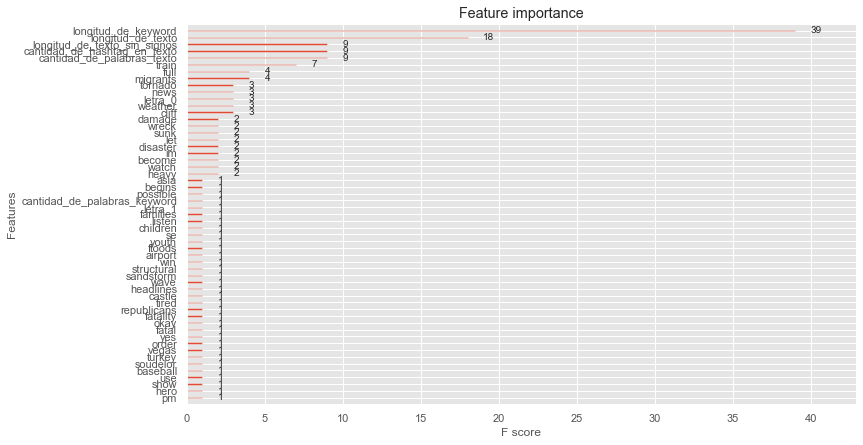

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

# Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=1, n_estimators = 20, max_features = 4, min_samples_split=10)
rf.fit(train_set, train_label)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), list(train_set.columns)),
             reverse=True))

Features sorted by their score:
[(0.1701, 'longitud_de_texto'), (0.16, 'longitud_de_texto_sin_signos'), (0.1212, 'longitud_de_keyword'), (0.0948, 'cantidad_de_palabras_texto'), (0.031, 'cantidad_de_hashtag_en_texto'), (0.0132, 'train'), (0.0095, 'disaster'), (0.0092, 'migrants'), (0.0091, 'families'), (0.0085, 'news'), (0.0071, 'full'), (0.0069, 'fatal'), (0.0051, 'weather'), (0.0047, 'soudelor'), (0.0046, 'rt'), (0.0046, 'let'), (0.0045, 'watch'), (0.0044, 'forest'), (0.0042, 'outrage'), (0.0042, 'earthquake'), (0.0041, 'sinkhole'), (0.0038, 'today'), (0.0038, 'floods'), (0.0035, 'turkey'), (0.0035, 'refugees'), (0.0035, 'pm'), (0.0035, 'hurricane'), (0.0033, 'heavy'), (0.0033, 'death'), (0.0032, 'cantidad_de_palabras_keyword'), (0.0031, 'things'), (0.0031, 'show'), (0.0031, 'im'), (0.003, 'rain'), (0.003, 'possible'), (0.003, 'island'), (0.003, 'derailment'), (0.0028, 'wave'), (0.0027, 'words'), (0.0027, 'airport'), (0.0026, 'damage'), (0.0025, 'youth'), (0.0025, 'wreck'), (0.0025, '

In [ ]:
train_set_best_features = train_set[['longitud_de_keyword', 'longitud_de_texto', 'cantidad_de_palabras_texto', 'cantidad_de_hashtag_en_texto']]
train_set_best_features.head()

,longitud_de_keyword,longitud_de_texto,cantidad_de_palabras_texto,cantidad_de_hashtag_en_texto
id,,,,
1,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0


In [ ]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'n_estimators', 
                                param_range=np.arange(1, 50),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

NameError: name 'validation_curve' is not defined

In [ ]:
train_mean = np.mean(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
plt.plot(np.arange(1, 50), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 50), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de n_estimators")
plt.ylabel("Accuracy Score")
plt.show()

NameError: name 'train_scoreNum' is not defined

In [ ]:
train_scoreNum_maxdepth, test_scoreNum_maxdepth = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'max_depth', 
                                param_range=np.arange(1, 15),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

NameError: name 'validation_curve' is not defined

In [ ]:
train_mean = np.mean(train_scoreNum_maxdepth, axis=1)
test_mean = np.mean(test_scoreNum_maxdepth, axis=1)
plt.plot(np.arange(1, 15), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 15), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de max_depth")
plt.ylabel("Accuracy Score")
plt.show()

NameError: name 'train_scoreNum_maxdepth' is not defined

In [ ]:
train_scoreNum_min_samples_split, test_scoreNum_min_samples_split = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'min_samples_split', 
                                param_range=np.arange(1, 30),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

NameError: name 'validation_curve' is not defined

In [ ]:
train_mean = np.mean(train_scoreNum_min_samples_split, axis=1)
test_mean = np.mean(test_scoreNum_min_samples_split, axis=1)
plt.plot(np.arange(1, 30), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 30), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de min_samples_split")
plt.ylabel("Accuracy Score")
plt.show()

NameError: name 'train_scoreNum_min_samples_split' is not defined

In [ ]:
train_scoreNum_min_samples_leaf, test_scoreNum_min_samples_leaf = validation_curve(
                                RandomForestClassifier(),
                                X = train_set_best_features, y = train_label, 
                                param_name = 'min_samples_leaf', 
                                param_range=np.arange(1, 20),
                                cv=3, 
                                scoring="accuracy", 
                                n_jobs=-1)

NameError: name 'validation_curve' is not defined

In [ ]:
train_mean = np.mean(train_scoreNum_min_samples_leaf, axis=1)
test_mean = np.mean(test_scoreNum_min_samples_leaf, axis=1)
plt.plot(np.arange(1, 20), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 20), test_mean, label="Testing score", color="dimgrey")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Valores de min_samples_leaf")
plt.ylabel("Accuracy Score")
plt.show()

NameError: name 'train_scoreNum_min_samples_leaf' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators = np.arange(1, 50)
max_depth = np.arange(1, 15)
min_samples_split = np.arange(1, 30)
min_samples_leaf = np.arange(1, 20)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(random_state = 1), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(train_set, train_label)

Fitting 3 folds for each of 377986 candidates, totalling 1133958 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

KeyboardInterrupt: 

In [ ]:
rf = RandomForestRegressor(random_state=5, n_estimators = 46, max_depth = 6, min_samples_split=47, min_samples_leaf = 27)
rf.fit(train_set, train_label)

RandomForestRegressor(max_depth=6, min_samples_leaf=27, min_samples_split=47,
                      n_estimators=46, random_state=5)

In [ ]:
predicts = rf.predict(test_set)
predicts += 0.21
result['target'] = predicts.round()
print(F1(result))

0.6314265025343954


In [ ]:
plt.barh(train_set.columns, rf.feature_importances_)
plt.xlabel('Features de train')
plt.ylabel('Importancia')
plt.title('Importancia vs Features con Random Forest')
plt.show()

KeyboardInterrupt: 

In [ ]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_ramdom_forest_busqueda_binaria():
    parametrosRFRandom_state = list(range(4,7,1))
    parametrosRFn_estimators = list(range(40,51,1))
    parametrosRFmax_features = list(range(4,7,1))
    parametrosRFmax_depth = list(range(1,51,2))
    parametrosRFmin_samples_split = list(range(1,31,1))
    listaDeParametros = [parametrosRFRandom_state,parametrosRFn_estimators,
                         parametrosRFmax_features,parametrosRFmax_depth,
                         parametrosRFmin_samples_split]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_Ramdom_forest)
    print("maximo {} parametros (iter,learning,profundidad,profundidad,samplesplit) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_ramdom_forest_busqueda_binaria()

[4, 40, 4, 1, 1]
[4, 40, 4, 1, 29]
[4, 40, 4, 1, 15]
[4, 40, 4, 1, 21]
[4, 40, 4, 1, 25]
[4, 40, 4, 1, 27]
[4, 40, 4, 49, 1]
[4, 40, 4, 49, 29]
[4, 40, 4, 49, 15]
[4, 40, 4, 49, 21]
[4, 40, 4, 49, 25]
[4, 40, 4, 49, 27]
[4, 40, 4, 25, 1]
[4, 40, 4, 25, 29]
[4, 40, 4, 25, 15]
[4, 40, 4, 25, 21]
[4, 40, 4, 25, 25]
[4, 40, 4, 25, 27]
[4, 40, 4, 37, 1]
[4, 40, 4, 37, 29]
[4, 40, 4, 37, 15]
[4, 40, 4, 37, 21]
[4, 40, 4, 37, 25]
[4, 40, 4, 37, 27]
[4, 40, 4, 43, 1]
[4, 40, 4, 43, 29]
[4, 40, 4, 43, 15]
[4, 40, 4, 43, 21]
[4, 40, 4, 43, 25]
[4, 40, 4, 43, 27]
[4, 40, 4, 45, 1]
[4, 40, 4, 45, 29]
[4, 40, 4, 45, 15]
[4, 40, 4, 45, 21]
[4, 40, 4, 45, 25]
[4, 40, 4, 45, 27]
[4, 40, 4, 47, 1]
[4, 40, 4, 47, 29]
[4, 40, 4, 47, 15]
[4, 40, 4, 47, 21]
[4, 40, 4, 47, 25]
[4, 40, 4, 47, 27]
[4, 40, 6, 1, 1]
[4, 40, 6, 1, 29]
[4, 40, 6, 1, 15]
[4, 40, 6, 1, 21]
[4, 40, 6, 1, 25]
[4, 40, 6, 1, 27]
[4, 40, 6, 49, 1]
[4, 40, 6, 49, 29]
[4, 40, 6, 49, 15]
[4, 40, 6, 49, 21]
[4, 40, 6, 49, 25]
[4, 40, 6, 49,

## Redes Neuronales

In [ ]:

def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_set.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               55168     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_set, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


................................

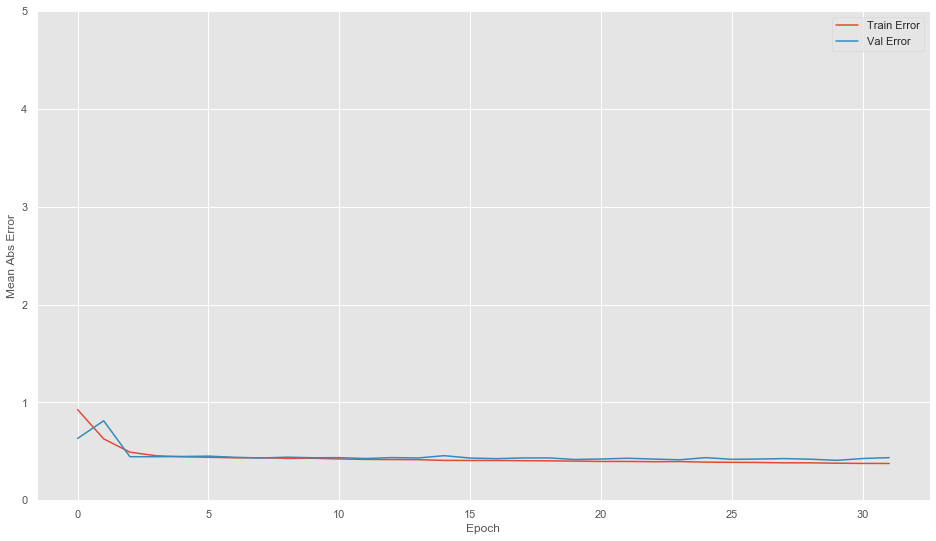

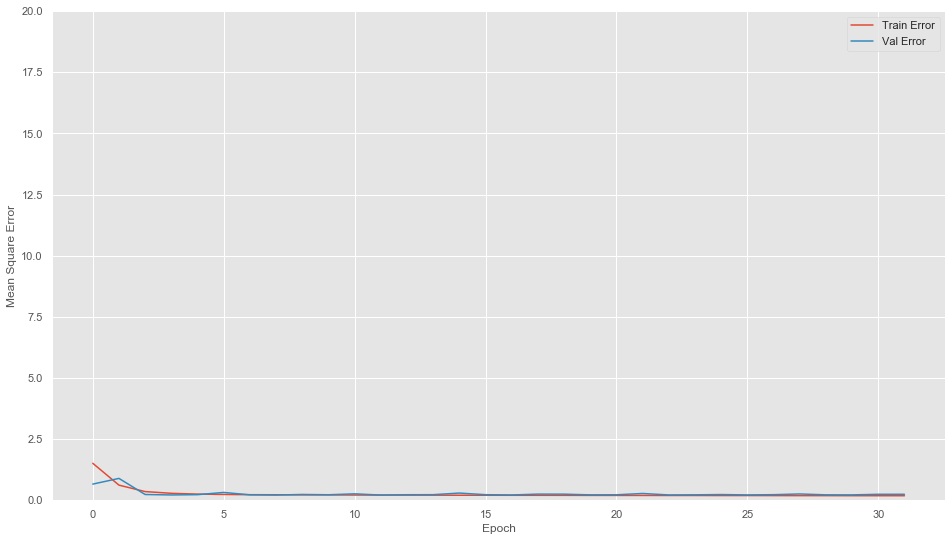

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
preds = model.predict(np.asarray(test_set)).round()
result['target'] = preds
print(F1(result))


0.6143465909090909


## TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='sag', C=10)
classifier.fit(train_set, train_label)

LogisticRegression(C=10, solver='sag')

In [ ]:
preds = classifier.predict(test_set)
result['target'] = preds
print(F1(result))

0.49274160099543757


In [ ]:
#NO EJECUTAR ESTA CELDA SALVO NESESIDAD DE ACTUALIZAR LAS PALABRAS IMPORTANTES
importancia = rf.feature_importances_
cols = test_set.columns
#dataImportacia = pd.DataFrame(columns=('importacia', 'col'))
#dataImportacia['importacia'] = importancia
#dataImportacia['col'] = cols
#dataImportacia = dataImportacia[dataImportacia['importacia'] > 0.001]
#dataImportacia.to_csv('impotacia.csv', index=False)#linea bloqueada por las dudas
cantidadImportantes = 0
for i in range(len(cols)):
    if (importancia[i] < 0.001):
        continue
    print(importancia[i],cols[i])
    cantidadImportantes += 1
print(cantidadImportantes,len(cols))
#dataImportacia.head()

0.2390805634162692 longitud_de_texto
0.10356755451085793 longitud_de_keyword
0.1495785422543723 cantidad_de_palabras_texto
0.00237350375031132 cantidad_de_palabras_keyword
0.04685193773478123 cantidad_de_hashtag_en_texto
0.004982539313145062 letra_0
0.003926678582109837 letra_1
0.004440598419622883 letra_2
0.005233410028750109 letra_3
0.0027622963481758874 earthquake
0.002358470515813103 everyone
0.0016901006666783641 street
0.001392154803011899 hey
0.00214993673194334 im
0.001033612848961267 song
0.0013459283696241483 traffic
0.002461013186582841 black
0.0033705876530110736 injured
0.001626441965061608 week
0.0012977403101263724 fall
0.001594919807935172 far
0.0010876019596148874 history
0.0010840221701216746 hard
0.002529627304767267 lol
0.0016005423181616816 fan
0.002106555365330004 god
0.0027767866723538053 air
0.0014003068324652227 island
0.0020361721529647578 times
0.007302318866651086 train
0.001051999048052131 die
0.0018248692018590466 change
0.0015764677032969036 latest
0.0015

# LightGBM

In [24]:
#los rangos se van afinando segun corren las pruevas
def busqueda_de_hiperparametros_optimos_LightGBM_busqueda_binaria():
    parametros_num_boost_round = list(range(50,151,10))
    parametros_early_stopping_rounds = list(range(10,51,10))
    parametrosDesviacion = list(range(-30,31,5))
    for i in range(len(parametrosDesviacion)):
        parametrosDesviacion[i] /= 100
    listaDeParametros = [parametros_num_boost_round,parametros_early_stopping_rounds,
                         parametrosDesviacion]
    maximo,parametros =busqueda_binaria_de_maximos(listaDeParametros,
                                                   [0,0,0],
                                                   0,
                                                   ultimo_Hiper_Parametro_LigthBM)
    print("maximo {} parametros (num_boost_round,early_stopping_rounds,desviacion) {}".format(maximo,parametros))
busqueda_de_hiperparametros_optimos_LightGBM_busqueda_binaria()

[50, 10, -0.3]
[1]	training's l2: 0.238768
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.233647
[3]	training's l2: 0.229373
[4]	training's l2: 0.225705
[5]	training's l2: 0.222512
[6]	training's l2: 0.219768
[7]	training's l2: 0.217214
[8]	training's l2: 0.21515
[9]	training's l2: 0.213287
[10]	training's l2: 0.211783
[11]	training's l2: 0.210319
[12]	training's l2: 0.209019
[13]	training's l2: 0.207734
[14]	training's l2: 0.206537
[15]	training's l2: 0.205388
[16]	training's l2: 0.204348
[17]	training's l2: 0.203463
[18]	training's l2: 0.202426
[19]	training's l2: 0.201533
[20]	training's l2: 0.200697
[21]	training's l2: 0.199798
[22]	training's l2: 0.19898
[23]	training's l2: 0.198141
[24]	training's l2: 0.197363
[25]	training's l2: 0.196771
[26]	training's l2: 0.196098
[27]	training's l2: 0.195571
[28]	training's l2: 0.195012
[29]	training's l2: 0.194231
[30]	training's l2: 0.193688
[31]	training's l2: 0.193103
[32]	training's l2: 0.192728
[33]	tr

In [70]:

lgb_train = lgb.Dataset(train_set, train_label)

params = {
    'objective': 'regression',
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_train,
                num_boost_round=100,
                early_stopping_rounds=10)

[1]	training's l2: 0.238768
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.233647
[3]	training's l2: 0.229373
[4]	training's l2: 0.225705
[5]	training's l2: 0.222512
[6]	training's l2: 0.219768
[7]	training's l2: 0.217214
[8]	training's l2: 0.21515
[9]	training's l2: 0.213287
[10]	training's l2: 0.211783
[11]	training's l2: 0.210319
[12]	training's l2: 0.209019
[13]	training's l2: 0.207734
[14]	training's l2: 0.206537
[15]	training's l2: 0.205388
[16]	training's l2: 0.204348
[17]	training's l2: 0.203463
[18]	training's l2: 0.202426
[19]	training's l2: 0.201533
[20]	training's l2: 0.200697
[21]	training's l2: 0.199798
[22]	training's l2: 0.19898
[23]	training's l2: 0.198141
[24]	training's l2: 0.197363
[25]	training's l2: 0.196771
[26]	training's l2: 0.196098
[27]	training's l2: 0.195571
[28]	training's l2: 0.195012
[29]	training's l2: 0.194231
[30]	training's l2: 0.193688
[31]	training's l2: 0.193103
[32]	training's l2: 0.192728
[33]	training's l2: 0.

In [73]:
preds = gbm.predict(test_set, num_iteration=gbm.best_iteration)
result = pd.read_csv('sample_submission.csv',index_col=['id'])
preds += 0.2
preds = preds.round()
result['target'] = preds
print(F1(result))

0.64317880794702


## ENTREGA

In [74]:
resultado_final = result#varia segun el metodo
#resultado_final.columns = ['id','target']
#resultado_final.reset_index()
resultado_final.head()

,target
id,
0,1.00
2,1.00
3,1.00
9,1.00
11,1.00


In [ ]:
#cuando todo termina el archivo de entrega
resultado_final.to_csv('submit.csv', index=False)